<a href="https://colab.research.google.com/github/aswinaus/Observability/blob/main/RAG_with_Evaluation_and_Inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install langchain langchain_community langchain_openai chromadb pymupdf nest_asyncio --quiet
from langchain_openai import OpenAIEmbeddings
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate

from langchain_core.runnables import (
    RunnableParallel,
    RunnablePassthrough
)
from langchain.schema.output_parser import StrOutputParser

Import the nest_asyncio library. This library provides a way to run asyncio code within an existing event loop, avoiding conflicts.

nest_asyncio.apply(): The core it "patches" the asyncio event loop to allow it to run inside the existing event loop of your environment. In simpler terms, it makes sure your asynchronous code plays nicely within the notebook environment without causing errors.

import os:  Line imports the os library, which is a standard Python library for interacting with the operating system.

In [ ]:
import nest_asyncio
import os
nest_asyncio.apply()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
import pymupdf

In [ ]:
# Download Data
data_dir = '/content/drive/MyDrive' # Input a data dir path from your mounted Google Drive

In [ ]:
doc = pymupdf.open(f"{data_dir}/RAG/data/TP/Intel_Financial_Statements_Year_Ended_2017.pdf")

In [ ]:
#Printing the content to validate
for page in doc:
    text = page.get_text()
    #print(text)

In [ ]:
import chromadb
from langchain.embeddings import OpenAIEmbeddings

In [ ]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyMuPDFLoader
pages=[]
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=300,
    chunk_overlap=50
)
loader = PyMuPDFLoader(f"{data_dir}/RAG/data/TP/Intel_Financial_Statements_Year_Ended_2017.pdf")
# load_and_split uses RecursiveCharacterTextSplitter by default
pages_to_persist = loader.load_and_split(text_splitter)
pages.extend(pages_to_persist)

In [ ]:
# split the pages into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
splits = text_splitter.split_documents(pages)

In [ ]:
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [ ]:
# create vector store with Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_community.vectorstores.utils import filter_complex_metadata # import filter_complex_metadata

vectordb = Chroma.from_documents(documents=pages, embedding=OpenAIEmbeddings(openai_api_key=os.environ["OPENAI_API_KEY"]),persist_directory=f"{data_dir}/RAG/VectorDB/chroma_db_RAG")
vectordb.persist()
retriever = vectordb.as_retriever()

In [ ]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

**RunnablePassthrough.assign():** This function is a core part of LangChain, a framework for building language model applications. RunnablePassthrough is like a pipe that allows data to flow through while potentially modifying or adding to it. .assign() is used here to add a new key-value pair to the data being passed through.

**context= :** This part specifies that the key we are adding is called context. The value associated with this key is determined by the expression on the right side of the equals sign. This context will hold the relevant information retrieved from the document.

**lambda x: :** This is an anonymous function (also called a lambda function) in Python. It takes one input (x, which will be a dictionary containing the user's question) and performs an operation to produce an output. This output becomes the value of the context key.

**vectordb.similarity_search(x["question"], k=10):** This is where the magic happens.

**vectordb** is a Chroma vector database containing the embeddings of the document you loaded earlier (Intel Financial Statements).
similarity_search is a method that searches the vector database for the documents most similar to a given query.

**x["question"]** provides the user's question as the query.

**k=10** specifies that we want to retrieve the top 10 most similar documents.

In [ ]:
#Creating a RAG Pipeline
from operator import itemgetter
from langchain.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
# RAG
template = """You are an AI language model Accounting assistant.Answer the following question based on this context:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
llm = ChatOpenAI(temperature=0, openai_api_key=os.environ["OPENAI_API_KEY"])
final_rag_chain = (
    #{"context": retriever | format_docs, "question": RunnablePassthrough()}

    RunnablePassthrough.assign(
        context=lambda x: format_docs(vectordb.similarity_search(x["question"], k=10)),
    )

    #| RunnablePassthrough.assign(debug_context=lambda x: print(f"Context before prompt: {x['context']}"))
    | prompt
    | llm
    | StrOutputParser()
)

In [ ]:
question="Can you let me know the Identified intangible assets subject to amortization and show the difference between 2016 and 2017?"

In [ ]:
final_rag_chain.invoke({"question":question})

In [ ]:
questions = [
    "Can you get the total amount of Goodwill and Identified Intangible Assets?",
    "How much did Intangibles such as Goodwill and other identified intangible assets did Intel gain by acquiring Altera in millions?",
    "Can you list all the Intel Goodwill activities for year 2017 along with figures in millions?",
    "Can let me know how much was spent on Data Center Group along for 2016 and 2017 and show the difference between 2016 and 2017?",
    "Can you let me know the Identified intangible assets subject to amortization and show the difference between 2016 and 2017?",
    ]
ground_truth = [
    "The total amount of Goodwill is $10,278 million, and the total amount of Identified Intangible Assets is $7,566 million.",
    "Intel gained $13,014 million in intangibles such as Goodwill and other identified intangible assets by acquiring Altera.",
    "Sure, here are the Intel Goodwill activities for the year 2017 along with figures in millions:- Client Computing Group: $4,356;- Data Center Group: $5,421;- Internet of Things Group: $1,126;- Programmable Solutions Group: $2,490;- All other: $10,996;Total: $24,389 million",
    "In 2016, the amount spent on the Data Center Group was $7,520 million, and in 2017, it was $8,395 million. The difference between the two years is $875 million, with an increase in spending on the Data Center Group from 2016 to 2017.",
    "The Identified intangible assets subject to amortization for 2016 were $8,686 million, and for 2017, they were $10,577 million. The difference between 2016 and 2017 is $1,891 million.",
    ]

In [ ]:
!pip install datasets --quiet
from datasets import Dataset

In [ ]:
answers  = []
contexts = []

# traversing each question and passing into the chain to get answer from the system
for question in questions:
    answers.append(final_rag_chain.invoke({"question":question}))
    contexts.append([docs.page_content for docs in retriever.get_relevant_documents(question)])

# Preparing the dataset
data = {
    "question": questions,
    "answer": answers,
    "contexts": contexts,
    "ground_truth": ground_truth
}

# Convert dict to dataset
dataset = Dataset.from_dict(data)

dataset.to_pandas()

In [ ]:
!pip install ragas --quiet
import ragas

In [ ]:
#!git clone https://github.com/aswinaus/rag_dataset_ragas.git
#%cd rag_dataset_ragas

In [ ]:
#from datasets import load_dataset
#dataset = load_dataset('json', data_files='RAGDataset.json')
#dataset = dataset['train']
#print(dataset)

Code is focused on evaluating the performance of a Retrieval Augmented Generation (RAG) system using the ragas library. RAG systems combine information retrieval (finding relevant documents) with text generation (creating answers).

**from ragas import evaluate:** This line imports the evaluate function from the ragas library. This function is the main tool for assessing the RAG system's quality.

**from ragas.metrics import (...):** Here, specific evaluation metrics are imported from ragas.metrics. These metrics will be used to judge different aspects of the system's performance.

**faithfulness:** Measures how well the generated answer aligns with the information provided in the retrieved documents. It checks if the answer is supported by the evidence.

**answer_relevancy:** Assesses the relevance of the generated answer to the user's question. It determines if the answer addresses the question appropriately.

**context_recall:** Evaluates how well the system retrieves all the necessary documents relevant to the question. A higher recall means more relevant documents are found.

**context_precision:** Measures the accuracy of the retrieved documents. A higher precision means that a larger proportion of the retrieved documents are actually relevant.

In [ ]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
)

result = evaluate(
    dataset=dataset,
    metrics=[
        context_precision,
        context_recall,
        faithfulness,
        answer_relevancy,
    ],
)

df = result.to_pandas()
df

In [ ]:
!pip install git+https://github.com/huggingface/transformers torch accelerate langchain autoawq --quiet

In [ ]:
!pip install langchain-huggingface
!pip install --upgrade transformers
!pip install autoawq

Code snippet is responsible for loading a pre-trained language model called "Mistral-Small-24B-Instruct-2501" from Hugging Face using specific optimizations for memory efficiency.

Please note here the Model was initially loaded from mistralai/Mistral-Small-24B-Instruct-2501 and saved locally for future use

Here, the code is setting up configuration for model quantization using

**BitsAndBytesConfig.**
Quantization is a technique used to reduce the memory footprint and computational requirements of a model by representing its weights and activations with lower precision (fewer bits).

**load_in_4bit=True** indicates that the model will be loaded using 4-bit quantization.

**bnb_4bit_compute_dtype=torch.bfloat16** specifies that the computations within the quantized model will be performed using a data type called "bfloat16" which offers a balance between precision and memory usage.

In [ ]:
!pip install decord

In [ ]:
from awq import AutoAWQForCausalLM
from transformers import AutoTokenizer
from typing import Tuple, Optional, Union, Dict, Any
from transformers import PreTrainedModel, AutoModel, AutoTokenizer, AutoConfig
from transformers.tokenization_utils_base import PreTrainedTokenizerBase
from google.colab import drive
from transformers import MistralForCausalLM, AutoTokenizer
import transformers
import torch
from langchain_huggingface import HuggingFacePipeline
from langchain_core.output_parsers import StrOutputParser
from langchain.prompts import PromptTemplate
from threading import Thread
device = 'cuda' if torch.cuda.is_available() else 'cpu'

first_token_time = 0
token_times = []

# Define the model ID for the desired model.
# Here the Model was initially loaded from mistralai/Mistral-Small-24B-Instruct-2501 and saved locally for future use.
#model_id = f"{data_dir}/LLMs/Mistral/Mistral-Small-24B-Instruct-2501"
model_path = f"{data_dir}/LLMs/Mistral/Mistral-Small-24B-Instruct-2501"
#model_path = 'mistralai/Mistral-Small-24B-Instruct-2501'
#quant_path = 'Mistral-Small-24B-Instruct-2501'

local_tokenizer = AutoTokenizer.from_pretrained(model_path)
local_model = MistralForCausalLM.from_pretrained(model_path,low_cpu_mem_usage=True)

**Saving the model and tokenizer allows to load them from my Google Drive, saving time and bandwidth.**

In [ ]:
#model.save_pretrained(f"{data_dir}/LLMs/Mistral")
#tokenizer.save_pretrained(f"{data_dir}/LLMs/Mistral")

In [ ]:
from langchain.prompts import PromptTemplate
streaming_inference(question)

LangChain provides a framework for building complex language model applications. By wrapping the Hugging Face model in a HuggingFacePipeline, it can be easily integrated with other LangChain components (like retrievers, prompts, and output parsers) to create a more sophisticated workflow.

**streamer =:** This part is simply assigning the created object to a variable named streamer. This allows you to refer to and use the streamer object later in your code.

**TextIteratorStreamer(...):** This is where the object is actually created. TextIteratorStreamer is a class from the transformers library designed to handle the streaming of text generation.

**tokenizer:** This argument is passing the tokenizer object you created earlier (tokenizer = AutoTokenizer.from_pretrained(model_id)). The tokenizer is responsible for breaking down the text into tokens that the model can understand.

**timeout=10.:** This sets a timeout of 10 seconds for the text queue. If the queue doesn't receive any new text within this time, it will raise a timeout exception. This helps to prevent the process from hanging indefinitely if there is a problem with the text generation.

**skip_prompt=True:** This tells the streamer to skip the initial prompt text when outputting the generated text. This is useful to avoid repeating the prompt that was already provided to the model.

**skip_special_tokens=True:** This instructs the streamer to skip any special tokens when outputting the generated text. Special tokens are often used by language models for internal purposes and are not meant to be part of the visible output.



TTFT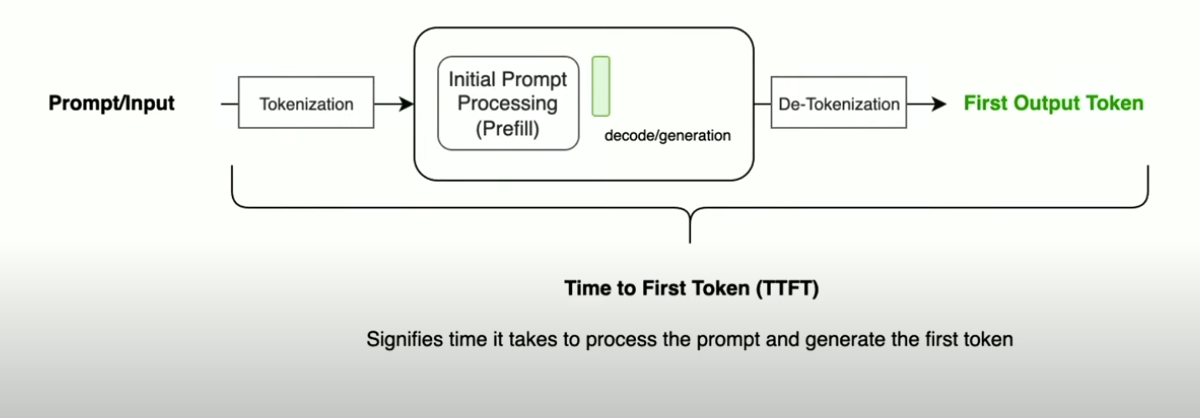

ITL 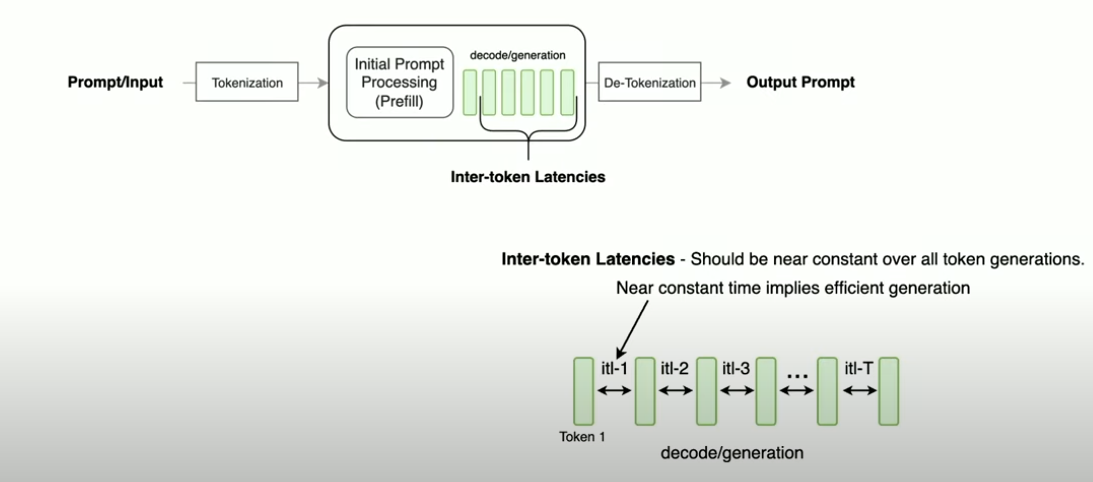

In [ ]:
def streaming_inference(question):

    context=retriever | format_docs
    #{"context": retriever | format_docs, "question": RunnablePassthrough()}
    print(f"Context before prompt: {context}")

    # Initialize a TextIteratorStreamer object for streaming text generation
    streamer = TextIteratorStreamer(tokenizer, timeout=10.,
                                    skip_prompt=True,
                                    skip_special_tokens=True)

    # Create a text generation pipeline using the Hugging Face transformers library
    text_generation_pipeline = transformers.pipeline(
        model=model,
        #The tokenizer variable (also defined earlier) is responsible for converting text into a format that the model can understand.
        tokenizer=tokenizer,
        task="text-generation",
        #This parameter controls the randomness of the generated text. Lower values (closer to 0) make the output more deterministic and focused, while higher values (closer to 1) introduce more creativity and randomness.
        temperature=0.3,
        #This parameter discourages the model from repeating the same phrases or words by penalizing repetitions in the generated text. A value greater than 1 increases the penalty for repetitions.
        repetition_penalty=1.1,
        #This limits the maximum number of new tokens (words or sub-words) that the model can generate.
        max_new_tokens=1000,
        #This enables sampling during text generation, allowing the model to explore different possibilities and produce more diverse outputs.
        do_sample= True,
        #This argument incorporates a streamer object (likely an instance of TextIteratorStreamer), enabling the pipeline to generate text in a streaming fashion. This means the text is produced and outputted gradually, rather than waiting for the entire generation process to complete before displaying any results. This is helpful for providing immediate feedback and handling long text generation tasks more efficiently.
        streamer=streamer  # Use the streamer for streaming text generation
    )

    prompt_template = """
    ### [INST]
    Instruction: You are an AI language model Accounting assistant.Answer the following question based on this context.

    ### CONTEXT:
    {context}

    ### QUESTION:
    {question}

    [/INST]
    """
    # Line is taking a Hugging Face text generation model (set up earlier in the code) and wrapping it in a LangChain object
    # so that it can be used as part of a larger language model application built with LangChain.
    mistral_llm = HuggingFacePipeline(pipeline=text_generation_pipeline)


    prompt = ChatPromptTemplate.from_template(prompt_template)
    llm = mistral_llm
    final_rag_chain = (
        #{"context": retriever | format_docs, "question": RunnablePassthrough()}

        RunnablePassthrough.assign(
            context=lambda x: format_docs(vectordb.similarity_search(x["question"], k=10)),
        )
        | prompt
        | llm
        | StrOutputParser()
    )

    input_text = {
        "context": context,
        "question": question
    }

    # Initialize variables for time measurements
    start_time = time.time()

    # Start a new thread to invoke the language model chain with the input text
    thread = Thread(target=final_rag_chain.invoke, args=[input_text])
    thread.start()

    # Initialize a variable to store the model output
    model_output = ""

    # Iterate over the streamer to get the generated text in chunks
    for i, new_text in enumerate(streamer):
        model_output += new_text
        print(new_text, end='')

        # Measure time for the first token
        if i == 0:
            first_token_time = time.time()
        # Measure time for each token
        token_times.append(time.time())

    # Calculate end-to-end latency
    end_time = time.time()
    end_to_end_latency = end_time - start_time

    # Calculate time to first token
    ttft = first_token_time - start_time

    # Calculate inter-token latency
    itl = sum(x - y for x, y in zip(token_times[1:], token_times[:-1])) / (len(token_times) - 1)

    # Calculate throughput
    throughput = len(tokenizer.encode(model_output)) / end_to_end_latency

    print("\n")  # Add a line break
    print("Printing Inference Metrics")
    print("\nTime To First Token (TTFT):", ttft)
    print("Inter-token latency (ITL):", itl)
    print("End-to-end Latency:", end_to_end_latency)
    print("Throughput:", throughput)
    print("\n")  # Add a line break
    # Return the metrics
    return {
        "TTFT": ttft,
        "ITL": itl,
        "End-to-end Latency": end_to_end_latency,
        "Throughput": throughput
    }